# Import libraries

In [14]:
import tensorflow as tf
import string
import re
import pandas as pd
import spacy
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB , MultinomialNB
from collections import Counter

# Load data

In [3]:
df_train = pd.read_csv ("hm_train.csv")
df_train.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,I went on a successful date with someone I fel...,1,affection
1,27674,24h,I was happy when my son got 90% marks in his e...,1,affection
2,27675,24h,I went to the gym this morning and did yoga.,1,exercise
3,27676,24h,We had a serious talk with some friends of our...,2,bonding
4,27677,24h,I went with grandchildren to butterfly display...,1,affection


In [4]:
df_test = pd.read_csv("hm_test.csv")
df_test.head()

,hmid,reflection_period,cleaned_hm,num_sentence
0,88305,3m,I spent the weekend in Chicago with my friends.,1
1,88306,3m,We moved back into our house after a remodel. ...,2
2,88307,3m,My fiance proposed to me in front of my family...,1
3,88308,3m,I ate lobster at a fancy restaurant with some ...,1
4,88309,3m,I went out to a nice restaurant on a date with...,5


# Data exploration & Wordcloud

In [5]:
import re
import string

def clean_text_round(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    return text

round_ = lambda x: clean_text_round(x)

In [6]:
clean_data = df_train['cleaned_hm'].apply(round_)

In [7]:
category_wise_test = df_train.groupby('predicted_category')['cleaned_hm'].apply(' '.join)
category_wise_test = category_wise_test.apply(round_)

In [8]:
df_category = pd.DataFrame({'category':category_wise_test.index , 'text':category_wise_test.values})

In [9]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(df_category['text'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = df_category['category']
data_dtm

,aa,aaa,aadat,aadhaar,aadhar,aagra,aakshayatriya,aam,aare,aashwin,...,zoomust,zootopia,zoowatching,zoowe,zoya,zucchini,zumba,zverev,zxc,zz
category,,,,,,,,,,,,,,,,,,,,,
achievement,2,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,2,3,0,1,0
affection,0,0,0,0,0,1,1,1,0,2,...,0,1,0,0,0,0,2,0,0,0
bonding,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
enjoy_the_moment,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
exercise,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
leisure,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,1,0,1
nature,0,0,0,0,0,0,0,0,0,0,...,1,0,1,2,0,0,0,0,0,0


In [10]:
tdm = data_dtm.transpose()

In [11]:
# Find the top 30 words for each category
data = tdm
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

In [12]:
# Let's first pull out the top 30 words for each category
words = []
for category in data.columns:
    top = [word for (word, count) in top_dict[category]]
    for t in top:
        words.append(t)

Counter(words).most_common()

[('got', 7),
 ('happy', 7),
 ('time', 7),
 ('day', 7),
 ('really', 7),
 ('went', 7),
 ('able', 6),
 ('good', 6),
 ('today', 6),
 ('yesterday', 6),
 ('long', 6),
 ('new', 5),
 ('work', 5),
 ('great', 4),
 ('night', 4),
 ('dinner', 3),
 ('nice', 3),
 ('going', 3),
 ('felt', 3),
 ('morning', 3),
 ('finally', 2),
 ('working', 2),
 ('did', 2),
 ('home', 2),
 ('birthday', 2),
 ('came', 2),
 ('life', 2),
 ('favorite', 2),
 ('feel', 2),
 ('saw', 2),
 ('job', 1),
 ('bought', 1),
 ('received', 1),
 ('won', 1),
 ('car', 1),
 ('money', 1),
 ('finished', 1),
 ('month', 1),
 ('months', 1),
 ('week', 1),
 ('getting', 1),
 ('project', 1),
 ('ago', 1),
 ('family', 1),
 ('son', 1),
 ('daughter', 1),
 ('husband', 1),
 ('wife', 1),
 ('dog', 1),
 ('girlfriend', 1),
 ('sister', 1),
 ('took', 1),
 ('mom', 1),
 ('friend', 1),
 ('friends', 1),
 ('old', 1),
 ('best', 1),
 ('met', 1),
 ('seen', 1),
 ('party', 1),
 ('fun', 1),
 ('school', 1),
 ('years', 1),
 ('lot', 1),
 ('ate', 1),
 ('happiness', 1),
 ('moment',

In [15]:
add_stop_words = [word for word, count in Counter(words).most_common() if count > 4]

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(df_category['text'])
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = df_category['category']

In [17]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

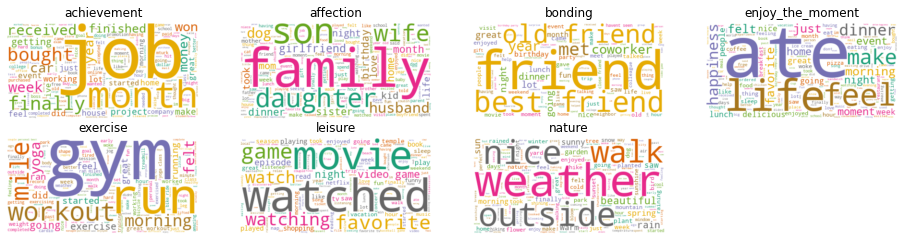

In [18]:
# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 6]

# Create subplots for each comedian
for index, category in enumerate(data.columns):
    wc.generate(df_category['text'][index])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(df_category['category'][index])
    
plt.show()

# Preprocessing

### 1. Cleaning

In [4]:
def clean(data):
    datarm=[]
    for i in data['cleaned_hm']:
        punct = re.sub(r'\W', ' ', i)
        non_num= re.sub ('[0-9]', '', punct)
        multiple_spaces = re.sub(' +',' ',non_num)
        newlines = str(multiple_spaces).replace("\n","")
        returns = str(newlines).replace("\r","")
        quotes = str(returns).replace("'","")
        datarm.append(quotes)
    return datarm

### 2. Lemmatization

In [5]:
def lemmatize(data):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    data_lemma = []
    for i in data:
        text = nlp(i)
        data_lemma.append([token.lemma_.lower().strip() for token in text])

    return data_lemma

### 3. Stopwords

In [222]:
def remove_stopwords(data):
    en_stop = nltk.corpus.stopwords.words('english')
    for sentence in data:
        for token in sentence:
            if token.lower() in en_stop:
                sentence.remove(token)
    data_stopped = [' '.join(i).lower() for i in data]   
    return data_stopped

In [278]:
def remove_commonwords(data):
    # to find 30 most commonly used words
    #print(data)
    all_words = []
    for i in data:
        for j in i.split(' '):
            all_words.append(j)
    d = Counter(all_words).most_common()[:10]
    d = [x[0] for x in d]
    print(d)
    final = []
    for i in data:
        querywords = i.split()
        resultwords  = [word for word in querywords if word.lower() not in d]
        result = ' '.join(resultwords)
        #print(result)
        
        final.append(result)
    return final

### Final preprocess function

In [280]:
def tokenize(data):
    tokenized = []
    for i in data:
        tokenized.append(i.split())
    return tokenized

In [281]:
def preprocess_data(data):
    cleaned=clean(data)
    lemmatized=lemmatize(cleaned)
    data_cleaned=remove_stopwords(lemmatized)
    data_cleaned = remove_commonwords(data_cleaned)
    return data_cleaned

In [282]:
df_train

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,I went on a successful date with someone I fel...,1,affection
1,27674,24h,I was happy when my son got 90% marks in his e...,1,affection
2,27675,24h,I went to the gym this morning and did yoga.,1,exercise
3,27676,24h,We had a serious talk with some friends of our...,2,bonding
4,27677,24h,I went with grandchildren to butterfly display...,1,affection
...,...,...,...,...,...
60316,88299,3m,I got together with my best friend and baked c...,1,bonding
60317,88300,3m,I went to a restaurant with friends,1,bonding
60318,88301,3m,The other day on Mechanical Turk I made over f...,1,achievement
60319,88302,3m,Finished the semester today and aced majority ...,2,achievement


In [283]:
X_train=preprocess_data(df_train)
X_train

['my', 'be', 'i', 'a', 'the', 'happy', 'get', 'go', 'make', 'have']


['successful date someone feel sympathy connection',
 'son mark his examination',
 'gym morning do yoga',
 'serious talk some friend ours flaky lately understand we good evening hang',
 'grandchild butterfly display crohn conservatory',
 'meditate last night',
 'new recipe peasant bread it come spectacular',
 'gift eld brother really surprising',
 'yesterday moms birthday enjoyed',
 'watch cupcake war three teen child',
 'come rd place call duty video game',
 'complete mile run without break feel strong',
 'movie friend fun',
 'short gold trade',
 'hear song can nearly impossible angry just look thought ease out your angry feeling move you direction happiness may take while long as you head in positive direction youall do world good',
 'son perform well test preparation',
 'help neighbour fix car damage',
 'manage final trophy game play',
 'hot kiss girl friend last night day',
 'new bcaa come mail yay strawberry lemonade flavor aminos heart',
 'got in class',
 'sister call from abroad

In [284]:
X_test=preprocess_data(df_test)
X_test

['my', 'be', 'i', 'the', 'a', 'get', 'happy', 'go', 'make', 'have']


['spend weekend chicago friend',
 'move back our house remodel live hotel month due our home severely damage tornado',
 'fiance propose front family beginning march',
 'eat lobster fancy restaurant some friend',
 'nice restaurant date wife very popular restaurant could reservation friend own famous hamburger place next door this restaurant able to table we great table great service great food they even compe of dinner we pay almost nothing',
 'leftovers come back tv',
 'very successful training work lead some important people take notice lot praise work',
 'able buy scrapbook supply sister law book her shower',
 'hockey game we win game',
 'see favorite band germany concert able actually meet and take photo they',
 'favorite noodle soup tonkotsu raman',
 'event when sister cheesy fire tofu eat two whole plate it',
 'event talk friend lymphoma experience severe short term memory loss able speak well well last time talk he could follow conversation',
 'new samsung galaxy',
 'turn march w

In [285]:
y_train=df_train['predicted_category']

In [286]:
label_encoder = LabelEncoder()
y_encode = label_encoder.fit_transform(y_train)
y_encode

array([1, 1, 4, ..., 0, 0, 1])

## Bag of Words & TF-IDF Vectorizer

In [287]:
Xtrain_clean=pd.bDataFrame({'data': X_train})
bow = CountVectorizer()          
bow.fit(Xtrain_clean['data'])               
X_bow = bow.transform(Xtrain_clean['data']) 

In [288]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(Xtrain_clean['data']) # vectorize feayures using tfidf

## Train-test split

In [289]:
def pred(X,y):

    X_train, X_test, y_train, y_test = train_test_split( X,
                                                         y,
                                                         test_size=0.2,
                                                         random_state=1) 

    knn = KNeighborsClassifier() 
    knn.fit(X_train, y_train) 
    knn_pred = knn.predict(X_test) 
    print("KNN: ",accuracy_score(y_test,knn_pred))
    
    forest = RandomForestClassifier()
    forest.fit(X_train,y_train)
    forest_pred = forest.predict(X_test)
    print("Random Forest: ",accuracy_score(y_test,forest_pred))
    
    lr = LogisticRegression() 
    lr.fit(X_train, y_train) 
    lr_pred = lr.predict(X_test)
    print("Logistic Regression: ",accuracy_score(y_test,lr_pred))
    
    nb = MultinomialNB()
    nb.fit(X_train,y_train)
    nb_pred = nb.predict(X_test)
    print("Naive Bayes: ",accuracy_score(y_test,nb_pred))
    
    #return accuracy_score(y_test, nb_pred)

In [290]:
X_tfidf

<60321x16022 sparse matrix of type '<class 'numpy.float64'>'
	with 535049 stored elements in Compressed Sparse Row format>

In [291]:
y_encode.shape

(60321,)

In [292]:
bow_accuracy=pred(X_tfidf ,y_encode)


KNN:  0.5562370493162039
Random Forest:  0.8498963945296312
Logistic Regression:  0.8804807293825114
Naive Bayes:  0.710236220472441


C:\Users\SHEM PEREIRA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Balance data using SMOTE

In [294]:
oversampling = SMOTE(sampling_strategy='auto')
X_new, y_new = oversampling.fit_resample(X_tfidf, y_encode) 
#y_new.value_counts()

## Train Machine Learning Algorithms:
####  KNearest Neighbors
####  Random Forest Classifier
####  Logistic Regression
####  Multinomial Naive Bayes

In [295]:
accuracy = pred(X_new , y_new)

KNN:  0.7614258347016968
Random Forest:  0.9473180076628352
Logistic Regression:  0.9365421455938697
Naive Bayes:  0.86353995621237


C:\Users\SHEM PEREIRA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Neural Network Model